#**Capstone Project - Computer Vision**
## **Milestone 1**

### **DOMAIN:**
Automotive. Surveillance.
### **CONTEXT:**
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is
predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of
the car, type, colour, number plates etc.
### **DATA DESCRIPTION:**
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g.
2012 Tesla Model S or 2012 BMW M3 coupe.
#### **Data description:**
* **Train Images:** Consists of real images of cars as per the make and year of the 
car.
* **Test Images:** Consists of real images of cars as per the make and year of the car.
* **Train Annotation:** Consists of bounding box region for training images.
* **Test Annotation:** Consists of bounding box region for testing images.
Dataset has been attached along with this project. Please use the same for this capstone project.
<br>Original link to the dataset: https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder
<br>Reference: 3D Object Representations for Fine-Grained Categorisation, Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei 4th IEEE
Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.

### **OBJECTIVE:**
Design a DL based car identification model.

Importing Tensorflow Version

In [2]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Defining Project Path

In [4]:
project_path = '/content/drive/My Drive/AIML/Capstone project/'

Importing Necessary Libraries

In [5]:
import pandas as pd
import numpy as np
import os

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input


# Initialize the random number generator
import random
random.seed(0)
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

Mapping CSV file to Annotation



In [6]:
class_names_data = pd.read_csv(project_path+"names.csv", header=None, names=["class_name"])
train_annotate = pd.read_csv(project_path+"anno_train.csv", header=None, names=["image_file","x0","y0","x1","y1","class"])
test_annotate = pd.read_csv(project_path+"anno_test.csv", header=None, names=["image_file","x0","y0","x1","y1","class"])

In [7]:
#Showing Top 10 label of Class Name
class_names_data.head(10)

,class_name
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [8]:
#Showing Top 10 label of Train Annotation
train_annotate.head(10)

,image_file,x0,y0,x1,y1,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
5,00006.jpg,259,289,515,416,123
6,00007.jpg,88,80,541,397,89
7,00008.jpg,73,79,591,410,96
8,00009.jpg,20,126,1269,771,167
9,00010.jpg,21,110,623,367,58


In [9]:
#Showing Top 10 label of Test Annotation
test_annotate.head(10)

,image_file,x0,y0,x1,y1,class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185
5,00006.jpg,20,77,420,301,78
6,00007.jpg,249,166,2324,1459,118
7,00008.jpg,119,215,1153,719,165
8,00009.jpg,1,7,275,183,32
9,00010.jpg,28,55,241,177,60


In [10]:
#Showing Example of Class Name Which contains Make, Model, Type, Year
class_names_data['class_name'][195]

'smart fortwo Convertible 2012'

Mapping Class Name file and Train Annotation file




In [11]:
train_annotate['class_name'] = train_annotate.apply(lambda x: class_names_data['class_name'][(x['class']-1)], axis=1)

In [12]:
#Showing mapping train annotation file
train_annotate

,image_file,x0,y0,x1,y1,class,class_name
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012
...,...,...,...,...,...,...,...
8139,08140.jpg,3,44,423,336,78,Chrysler Town and Country Minivan 2012
8140,08141.jpg,138,150,706,523,196,smart fortwo Convertible 2012
8141,08142.jpg,26,246,660,449,163,Mercedes-Benz SL-Class Coupe 2009
8142,08143.jpg,78,526,1489,908,112,Ford GT Coupe 2006


In [13]:
train_annotate.iloc[10]

image_file                  00011.jpg
x0                                 51
y0                                 93
x1                                601
y1                                393
class                              49
class_name    Buick Verano Sedan 2012
Name: 10, dtype: object

Defining image path file list

In [14]:
def get_image_file_list(image_path):
  train_image_dir = os.listdir(image_path)
  train_image_list=[]
  for i in train_image_dir:
    for f in os.listdir(os.path.join(image_path, i)):
              # Check file extension. Allow only jpg/jpeg' files.
              ext = os.path.splitext(f)[1]
              if ext == '.jpg' or ext == '.jpeg':
                train_image_list.append("{}/{}".format(i,f))
  return train_image_list

Defining image path list

In [15]:
def map_image_metadata(image_base_path, annotate_metadata, image_path_list):
  image_path_lst_split = [i.split('/')[1] for i in image_path_list]
  annotate_metadata["car_image_path"] = annotate_metadata.apply(
      lambda row: image_base_path+'/'+ image_path_list[image_path_lst_split.index(row['image_file'])], 
      axis=1)
  return annotate_metadata

Mapping Training Annoatation and Image Path

In [16]:
train_image_path = project_path+"car_data/car_data/train"
train_image_list = get_image_file_list(train_image_path)
train_annotate = map_image_metadata(train_image_path, train_annotate, train_image_list)

In [17]:
train_annotate.head(11)

,image_file,x0,y0,x1,y1,class,class_name,car_image_path
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,/content/drive/My Drive/AIML/Capstone project/...
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,/content/drive/My Drive/AIML/Capstone project/...
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,/content/drive/My Drive/AIML/Capstone project/...
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,/content/drive/My Drive/AIML/Capstone project/...
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,/content/drive/My Drive/AIML/Capstone project/...
5,00006.jpg,259,289,515,416,123,Geo Metro Convertible 1993,/content/drive/My Drive/AIML/Capstone project/...
6,00007.jpg,88,80,541,397,89,Dodge Journey SUV 2012,/content/drive/My Drive/AIML/Capstone project/...
7,00008.jpg,73,79,591,410,96,Dodge Charger Sedan 2012,/content/drive/My Drive/AIML/Capstone project/...
8,00009.jpg,20,126,1269,771,167,Mitsubishi Lancer Sedan 2012,/content/drive/My Drive/AIML/Capstone project/...
9,00010.jpg,21,110,623,367,58,Chevrolet Traverse SUV 2012,/content/drive/My Drive/AIML/Capstone project/...


Defining Show Image Function

In [18]:
def show_image(metadata):
  img = cv2.imread(metadata['car_image_path'],1)
  plt.imshow(img)
  plt.show()

Defining Bounding Box function

In [19]:
def show_image_with_bb(df):
  img = cv2.imread(df.car_image_path,1)
  x0=df.x0
  x1=df.x1
  y0=df.y0
  y1=df.y1


  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = patches.Rectangle((x0,y0), (x1-x0),(y1-y0),
                          linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.title(df.class_name)
  plt.show()

Printing Sample Train Image Metadata

In [21]:
df = train_annotate.iloc[10]
df

image_file                                                00011.jpg
x0                                                               51
y0                                                               93
x1                                                              601
y1                                                              393
class                                                            49
class_name                                  Buick Verano Sedan 2012
car_image_path    /content/drive/My Drive/AIML/Capstone project/...
Name: 10, dtype: object

Showing Sample Train Image

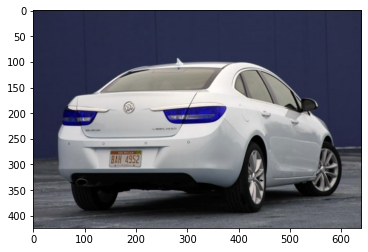

In [22]:
show_image(df)

Showing Image with Bounding Box

In [23]:
df['car_image_path']

'/content/drive/My Drive/AIML/Capstone project/car_data/car_data/train/Buick Verano Sedan 2012/00011.jpg'

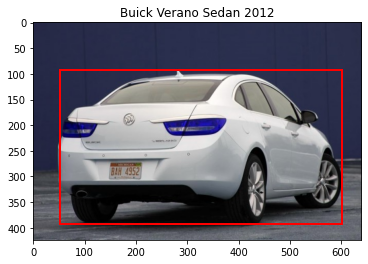

In [24]:
show_image_with_bb(df)

Mapping Test Annotation file to Class Name

In [25]:
test_annotate['class_name'] = test_annotate.apply(lambda x: class_names_data['class_name'][(x['class']-1)], axis=1)

In [26]:
test_image_path = project_path+"car_data/car_data/test"
test_image_list = get_image_file_list(test_image_path)
test_annotate = map_image_metadata(test_image_path, test_annotate, test_image_list)

In [27]:
df = test_annotate.iloc[10]
df

image_file                                                00011.jpg
x0                                                               30
y0                                                               20
x1                                                              438
y1                                                              253
class                                                            49
class_name                                  Buick Verano Sedan 2012
car_image_path    /content/drive/My Drive/AIML/Capstone project/...
Name: 10, dtype: object

Showing Sample Test Image

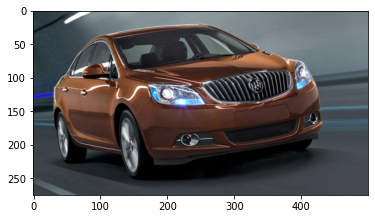

In [28]:
show_image(df)

Showing Sample Test Image with Bounding Box

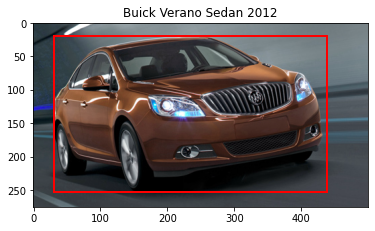

In [29]:
show_image_with_bb(df)

In [30]:
ALPHA = 1

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 32
WIDTH_CELLS = 32

IMAGE_SIZE = 224

In [31]:
img = cv2.imread(df['car_image_path'],1)

In [32]:
img_resized = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)

In [33]:
img = cv2.UMat(cv2.imread(df['car_image_path'],1))

In [34]:
img.get().shape

(275, 500, 3)

In [ ]:
df.x1

438

Resizing the image to take them as input to mobilenet
* resizing all the input images to same size (in this case 224,244)
* resizing the boumding boxes to the normalized image size
* making the bounding box as height and width, instead of starting and ending points
* setting the class as target variables

In [35]:
def resize_image_data(annotate):
    resized_images = []
    images_bb = []
    images_class = []

    for index, rows in annotate.iterrows():
        img = cv2.UMat(cv2.imread(rows['car_image_path'],1)).get()
        img_resized = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)
        #geting the height and width for the bounding box
        img_hw = np.zeros((4,1), dtype=np.float32)

        img_hw[0] = rows['x0']*IMAGE_WIDTH/img.shape[1]
        img_hw[1] = rows['y0']*IMAGE_HEIGHT/img.shape[0]
        img_hw[2] = (rows['x1']-rows['x0'])*IMAGE_WIDTH/img.shape[1]
        img_hw[3] = (rows['y1']-rows['y0'])*IMAGE_HEIGHT/img.shape[0]

        images_bb.append(img_hw)
        resized_images.append(preprocess_input(np.array(img_resized, dtype=np.float32)))
        images_class.append(rows['class'])
        
        print("Index:{}".format(index))
        print(img_hw)
        del img, img_resized, img_hw

    return resized_images, images_bb, images_class

In [39]:
def resize_image_data(annotate):
    resized_images = []
    images_bb = []
    images_class = []

    for index, rows in annotate.iterrows():
        img = cv2.UMat(cv2.imread(rows['car_image_path'],1)).get()
        #img_resized = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)
        #geting the height and width for the bounding box
        img_hw = np.zeros((4,1), dtype=np.float32)

        img_hw[0] = rows['x0']*IMAGE_WIDTH/img.shape[1]
        img_hw[1] = rows['y0']*IMAGE_HEIGHT/img.shape[0]
        img_hw[2] = (rows['x1']-rows['x0'])*IMAGE_WIDTH/img.shape[1]
        img_hw[3] = (rows['y1']-rows['y0'])*IMAGE_HEIGHT/img.shape[0]

        images_bb.append(img_hw)
        #resized_images.append(preprocess_input(np.array(img_resized, dtype=np.float32)))
        #images_class.append(rows['class'])
        
        #print("Index:{}".format(index))
        #print(img_hw)
        del img, img_hw

    return images_bb

In [40]:
import datetime
print("Time Now: {}".format(datetime.datetime.now()))
train_bb = resize_image_data(train_annotate)

print("Time Now: {}".format(datetime.datetime.now()))

Time Now: 2021-02-21 08:38:27.349397
Time Now: 2021-02-21 09:23:39.837663


In [ ]:
len(train_images)

8144

In [ ]:
len(train_bb)

8144

In [42]:
data_path = "/content/drive/My Drive/AIML/Image_data_caps/"

In [ ]:
np.save(data_path+"train_images.npy",train_images)

In [43]:
np.save(data_path+"train_bb.npy", train_bb)

In [ ]:
np.save(data_path+"train_classes.npy", train_class)

In [54]:
train_images = np.load(data_path+"train_images.npy")
train_bb = np.load(data_path+"train_bb.npy")
train_class = np.load(data_path+"train_classes.npy")

In [ ]:
len(train_bb_drive)

8144

In [ ]:
project_path

'/content/drive/My Drive/AIML/Capstone project/'

In [44]:
print("Time Now: {}".format(datetime.datetime.now()))
test_bb = resize_image_data(test_annotate)

print("Time Now: {}".format(datetime.datetime.now()))

Time Now: 2021-02-21 09:30:53.212283
Time Now: 2021-02-21 10:17:24.168784


In [ ]:
test_images, test_bb, test_class = resize_image_data(test_annotate)

Streaming output truncated to the last 5000 lines.
Index:3041
Index:3042
Index:3043
Index:3044
Index:3045
Index:3046
Index:3047
Index:3048
Index:3049
Index:3050
Index:3051
Index:3052
Index:3053
Index:3054
Index:3055
Index:3056
Index:3057
Index:3058
Index:3059
Index:3060
Index:3061
Index:3062
Index:3063
Index:3064
Index:3065
Index:3066
Index:3067
Index:3068
Index:3069
Index:3070
Index:3071
Index:3072
Index:3073
Index:3074
Index:3075
Index:3076
Index:3077
Index:3078
Index:3079
Index:3080
Index:3081
Index:3082
Index:3083
Index:3084
Index:3085
Index:3086
Index:3087
Index:3088
Index:3089
Index:3090
Index:3091
Index:3092
Index:3093
Index:3094
Index:3095
Index:3096
Index:3097
Index:3098
Index:3099
Index:3100
Index:3101
Index:3102
Index:3103
Index:3104
Index:3105
Index:3106
Index:3107
Index:3108
Index:3109
Index:3110
Index:3111
Index:3112
Index:3113
Index:3114
Index:3115
Index:3116
Index:3117
Index:3118
Index:3119
Index:3120
Index:3121
Index:3122
Index:3123
Index:3124
Index:3125
Index:3126
Ind

In [ ]:
len(test_images)

8041

In [46]:
data_path

'/content/drive/My Drive/AIML/Image_data_caps/'

In [ ]:
np.save(data_path+"test_images.npy",test_images)

In [47]:
np.save(data_path+"test_bb.npy", test_bb)
#np.save(data_path+"test_classes.npy", test_class)

In [55]:
test_images = np.load(data_path+"test_images.npy")
test_bb = np.load(data_path+"test_bb.npy")
test_class = np.load(data_path+"test_classes.npy")

In [56]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Conv2D, Reshape, Dense
from tensorflow.keras.models import Model

In [57]:
def create_classification_model(trainable=True):
    model = MobileNetV2(
            input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet',
            classifier_activation='softmax')

    for layer in model.layers:
        layer.trainable = trainable

    x=model.output
    x=Flatten()(x)
    x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x=Dense(1024,activation='relu')(x) #dense layer 2
    x=Dense(512,activation='relu')(x) #dense layer 3
    x=Dense(196,activation='softmax')(x) #final layer with softmax activation

    return Model(inputs=model.input, outputs=x)

In [58]:
def create_bb_model(trainable=True):
    model = MobileNetV2(
            input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet',
            classifier_activation='softmax')

    for layer in model.layers:
        layer.trainable = trainable

    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=7, name="coords")(x0)
    x2 = Reshape((4,))(x1) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=x2)

In [59]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [60]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

In [61]:
classification_model = create_classification_model(False)
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [62]:
bb_model = create_bb_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
bb_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [63]:
classification_model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE

In [64]:
bb_model.compile(loss="softmax_cross_entropy", optimizer="adam", metrics="accuracy")

In [65]:
train_images[10]

array([[[-0.70980394, -0.69411767, -0.4588235 ],
        [-0.70980394, -0.69411767, -0.4588235 ],
        [-0.7019608 , -0.6862745 , -0.45098037],
        ...,
        [-0.6627451 , -0.6313726 , -0.41176468],
        [-0.67058825, -0.6392157 , -0.41960782],
        [-0.6784314 , -0.64705884, -0.42745095]],

       [[-0.7176471 , -0.7019608 , -0.46666664],
        [-0.7176471 , -0.7019608 , -0.46666664],
        [-0.70980394, -0.69411767, -0.4588235 ],
        ...,
        [-0.67058825, -0.6392157 , -0.41960782],
        [-0.67058825, -0.6392157 , -0.41960782],
        [-0.6784314 , -0.64705884, -0.42745095]],

       [[-0.7176471 , -0.7019608 , -0.46666664],
        [-0.7176471 , -0.7019608 , -0.46666664],
        [-0.70980394, -0.69411767, -0.4588235 ],
        ...,
        [-0.67058825, -0.6392157 , -0.41960782],
        [-0.67058825, -0.6392157 , -0.41960782],
        [-0.6862745 , -0.654902  , -0.4352941 ]],

       ...,

       [[-0.42745095, -0.38823527, -0.31764704],
        [-0

In [66]:
image1 = (train_images[10]*255).astype(np.uint8)
image2 = ((train_images[10]*255)+255%255).astype(np.uint8)

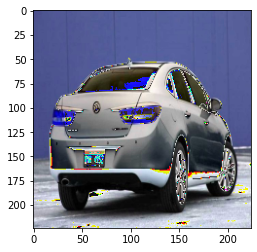

In [67]:
from PIL import Image
img = Image.fromarray(image1)
plt.imshow(img)
plt.show()

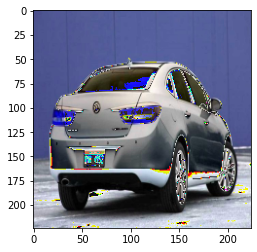

In [68]:
from PIL import Image
img = Image.fromarray(image2)
plt.imshow(img)
plt.show()

In [69]:
df = train_annotate.iloc[10]

In [72]:
x0 = train_bb[10][0]
x1 = train_bb[10][1]
wid = train_bb[10][2]
hght = train_bb[10][3]
print("{}   {}   {}  {}".format(x0,y0,wid,hght))

[17.85]   93   [192.5]  [158.49057]


In [79]:
train_bb[10][1]

array([49.132076], dtype=float32)

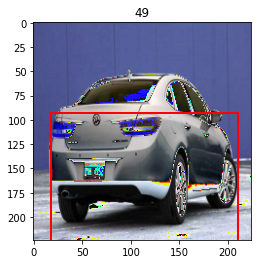

In [73]:
fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((x0,y0), wid, hght,
                          linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.title(train_class[10])
plt.show()

In [61]:
image2

array([[[ 75,  79, 140],
        [ 75,  79, 140],
        [ 77,  81, 142],
        ...,
        [ 87,  95, 152],
        [ 85,  93, 150],
        [ 83,  91, 148]],

       [[ 73,  77, 138],
        [ 73,  77, 138],
        [ 75,  79, 140],
        ...,
        [ 85,  93, 150],
        [ 85,  93, 150],
        [ 83,  91, 148]],

       [[ 73,  77, 138],
        [ 73,  77, 138],
        [ 75,  79, 140],
        ...,
        [ 85,  93, 150],
        [ 85,  93, 150],
        [ 81,  89, 146]],

       ...,

       [[148, 158, 176],
        [146, 158, 174],
        [132, 144, 158],
        ...,
        [204, 208, 230],
        [196, 200, 222],
        [190, 194, 214]],

       [[156, 166, 184],
        [140, 150, 166],
        [132, 144, 158],
        ...,
        [190, 194, 216],
        [186, 190, 212],
        [190, 194, 214]],

       [[170, 174, 194],
        [176, 182, 200],
        [188, 194, 210],
        ...,
        [188, 192, 214],
        [188, 192, 212],
        [202, 206, 226]]

In [62]:
image1

array([[[ 75,  79, 140],
        [ 75,  79, 140],
        [ 77,  81, 142],
        ...,
        [ 87,  95, 152],
        [ 85,  93, 150],
        [ 83,  91, 148]],

       [[ 73,  77, 138],
        [ 73,  77, 138],
        [ 75,  79, 140],
        ...,
        [ 85,  93, 150],
        [ 85,  93, 150],
        [ 83,  91, 148]],

       [[ 73,  77, 138],
        [ 73,  77, 138],
        [ 75,  79, 140],
        ...,
        [ 85,  93, 150],
        [ 85,  93, 150],
        [ 81,  89, 146]],

       ...,

       [[148, 158, 176],
        [146, 158, 174],
        [132, 144, 158],
        ...,
        [204, 208, 230],
        [196, 200, 222],
        [190, 194, 214]],

       [[156, 166, 184],
        [140, 150, 166],
        [132, 144, 158],
        ...,
        [190, 194, 216],
        [186, 190, 212],
        [190, 194, 214]],

       [[170, 174, 194],
        [176, 182, 200],
        [188, 194, 210],
        ...,
        [188, 192, 214],
        [188, 192, 212],
        [202, 206, 226]]

In [76]:
classification_history = classification_model.fit(
                          x=train_images, y=train_class, batch_size=32, 
                          epochs=100, validation_data=(test_images,test_class))

Epoch 1/100


UnknownError: ignored

In [75]:
bb_history = bb_model.fit(
                          x=train_images, y=train_bb, batch_size=32, 
                          epochs=100, validation_data=(test_images,test_bb))

Epoch 1/100


ValueError: ignored